# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.

Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved. 


 The first stage where sampling occurs is when infecting a random subset of people. The function `np.random.choice()` performs simple random sampling without replacement, where every value has an equal chance of being selected as an infectd individual. The sample size is 100 individuals (`ATTACK_RATE` * 1000). The sampling frame is the community of 1000 individuals (200 wedding attendees, 800 brunch attendees). A discrete, finite, uniform distribution is assumed. It's uniform because every individual has an equal chance of being selected.

 The second stage is primary contact tracing. The function `np.random.rand()` returns a number between 0 and 1 for each infected individual (determined by the sum of infected individuals within the data frame). The output is then compared against the `TRACE_SUCCESS` value, and those that are below the threshold are `TRUE` and those above are `FALSE`, and the output is a binomial distribution. The sample size are those that then are assigned a TRUE value, and the sampling frame is all of those individuals who are infected.

This isn't random sampling, but the third stage is secondary contact tracing. If the number of infected and traced individuals is at or above the `SECONDARY_TRACE_THRESHOLD` value, then all infected individuals who attended that event will be traced. This is a non-random sampling and is based on the second stage's random sampling.




Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

**n = 10**
The results are very dynamic with such a small sample size. Each simulation yielded a different pattern of results - for example, one simulation showed results from only those traced at weddings, and the next simulation had an equal split. The mean proportions varied significantly with each simulation as well. Such a small sample size makes it very difficult to reproduce the results from simulation to simulation.


**n = 100**
The pattern of results are becoming more consistent with each simulation than with ten simulations. For example, the left skew of the results becomes more consistent across simulations, but the mean proportion still changes with each simulation. As such, this is still not ideal for reproducibility.

Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The script needs to produce the same output when run multiple times.

I added a random seed (`np.random.seed(387)`) before the function for reproducibility. The seed sets an identical state for each run. In other words, it ensures that the same individuals are selected at each sampling stage, and that the results are the same for each simulation.

## Code

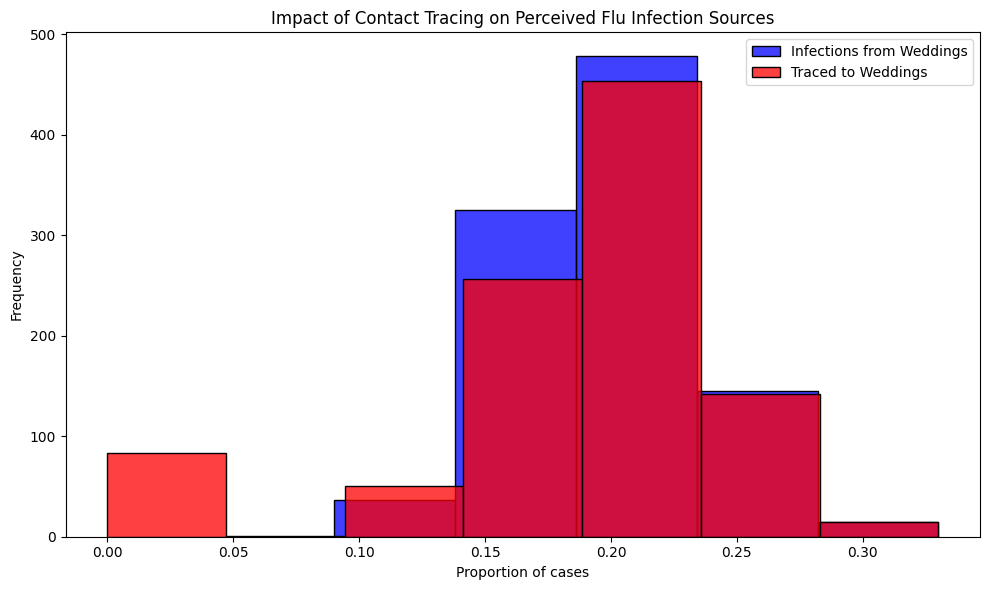

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set random seed for reproducibility
np.random.seed(387)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 06 January 2026`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
